[528.43804585]
Maximum EQE: 0.01%
Maximum Luminance: 587.50cd/m2


/var/folders/vl/5k9cn_bd01303bqb1jnhn4d00000gn/T/ipykernel_45607/583747198.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('PuBu', 8)
/var/folders/vl/5k9cn_bd01303bqb1jnhn4d00000gn/T/ipykernel_45607/583747198.py:141: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('PuBu', 8)


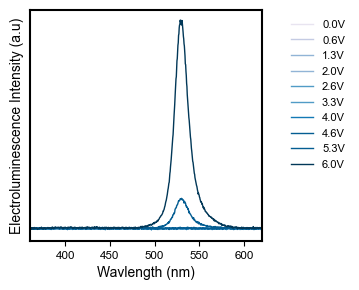

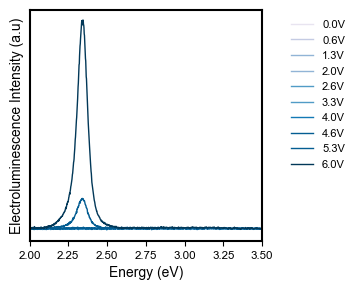

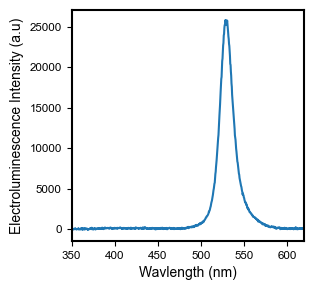

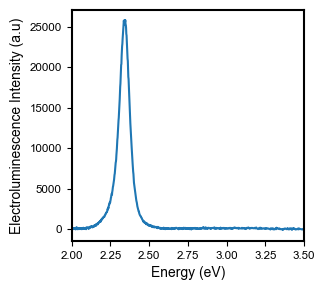

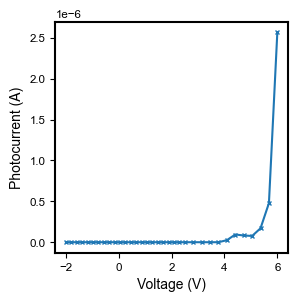

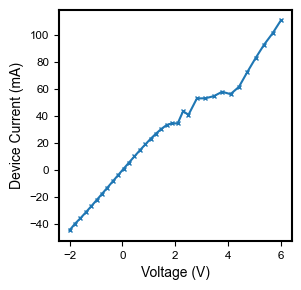

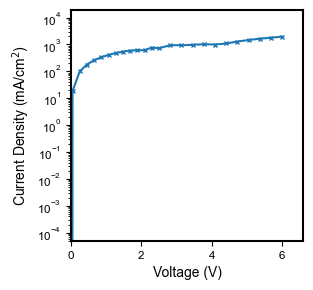

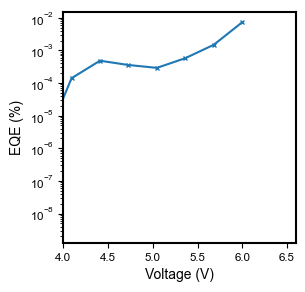

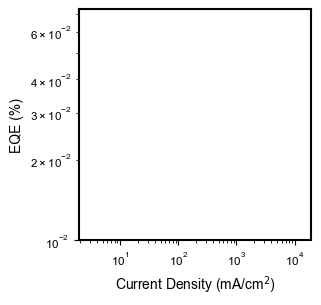

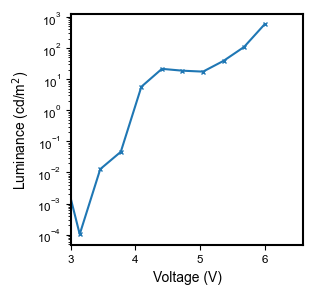

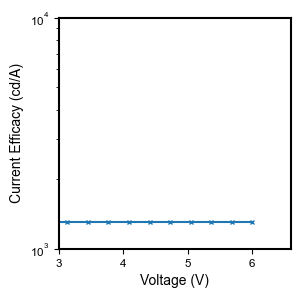

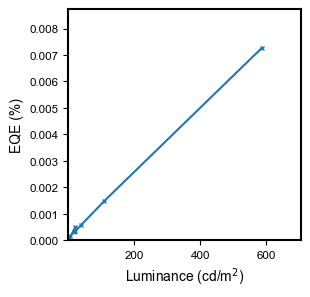

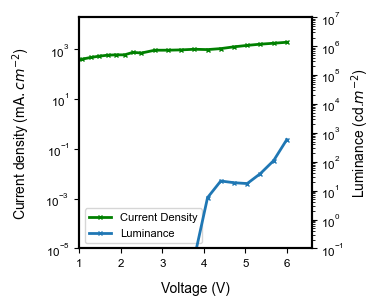

In [23]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 15 19:19:15 2017

@author: mziffer
@adapted by: gillian shen 
#Adapted for normalized spectral distribution inputs, with calculations based on 
Anaya, M. et al. Best practices for measuring emerging light-emitting diode technologies. Nat Photonics 13, 818–821 (2019).
"""

import numpy as np
import matplotlib.cm as cm
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.constants as constants
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc('font', family='Arial')
plt.rcParams['axes.linewidth'] = 1.5
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
plt.rcParams['font.size'] = 10

"""User inputs here"""
device_region = 'B'
jvl_filename = r'../QLED_testing/IV+Spectra2/2024-02-08QD41_YZ-XIV-69_PVK_B6_p8_-2.0V-6.0V_IV+photocurrent' #DO NOT ENTER '.txt'
el_spectrum_filename = r'../QLED_testing/IV+Spectra2/2024-02-08QD41_YZ-XIV-69_PVK_B6_p8_0.0V-6.0V_0.2s_spectra'
 

Background_spectrum_override= False
background_spectrum_filename = r'../QLED_testing/IV+Spectra2/2023-11-02QD33_50Br_NSA_PVK_B1_higherV_blank_spectra'
#2023-07-14ZW_Yunping_A4_unencapsulated_spectra' #DO NOT ENTER '.txt'

#Override EL spectrum with QD PL spectrum (if no EL data available)
Override=False
pl_spectrum = pd.read_csv("../../20230922/QD33_NoNSA#02.sp", skiprows=53, sep='\t').reset_index().to_numpy()
#pd.read_csv("../../20230921/QD32_NoNSA#02.sp", skiprows=53, sep='\t').reset_index().to_numpy()

"""EL spectrum should be in units of photons * s^-1 * nm^-1"""

pixel_area = 0.057 #in cm^2 #1.08 for full?
#0.0605 #cm2 without mask

"""DO NOT EDIT BELOW"""

e_charge = constants.physical_constants['elementary charge'][0] 
h = constants.physical_constants['Planck constant'][0]
c = (constants.physical_constants['speed of light in vacuum'][0])

el_spec_file = np.loadtxt(el_spectrum_filename + '.csv', delimiter = '\t')
jvl_data = np.loadtxt(jvl_filename + '.csv', delimiter = '\t', skiprows = 1)
el_spectrum_pandas = pd.read_csv(el_spectrum_filename+'.csv', delimiter = '\t')

background_spectrum_file=np.loadtxt(background_spectrum_filename + '.csv', delimiter = '\t')

spectra_volts = list(el_spectrum_pandas.columns)
new_spectra_volts = []
for i in range(len(spectra_volts)):
    result=''
    result = ''.join([j for j in spectra_volts[i][:3] if not j.isalpha()])
    new_spectra_volts.append(result)

el_spec_nm = np.copy(el_spec_file[:,0])
el_spec_background= np.copy(el_spec_file[:,1])

if Background_spectrum_override:
    el_spec_background= np.copy(background_spectrum_file[:,-1])

el_spec_au= np.copy(el_spec_file[:,-1])-el_spec_background
el_spec_norm = el_spec_au/np.amax(el_spec_au)
#el_spec_photons_s =  np.copy(el_spec_file[:,-1])
e_photon = h * c / (el_spec_nm * 1e-9)
e_photon_avg = np.trapz(el_spec_norm*e_photon, x = el_spec_nm)/np.trapz(el_spec_norm, x = el_spec_nm)
#el_spec_w = el_spec_photons_s * e_photon



volts = np.copy(jvl_data[:,0])
pd_current_array = np.copy(jvl_data[:,2]-jvl_data[0,2])/1000 # In units of Amps
device_current_array = np.copy(jvl_data[:,1])/1000 # In units of Amps
max_driving_voltage=np.amax(volts)
max_current_density=np.amax(device_current_array)*1000/pixel_area

if Override:
    el_spec_nm = np.copy(pl_spectrum[:,0])
    el_spec_au = np.copy(pl_spectrum[:,1])
    el_spec_norm = el_spec_au/np.amax(el_spec_au)
    #el_spec_photons_s =  np.copy(el_spec_file[:,-1])
    e_photon = h * c / (el_spec_nm * 1e-9)
    e_photon_avg = np.trapz(el_spec_norm*e_photon, x = el_spec_nm)/np.trapz(el_spec_norm, x = el_spec_nm)
    
    eVs = [] #np.zeros((len(el_spec_nm)))
    for i in el_spec_nm:
        e=(h*c/(i*1e-9))/e_charge
        eVs.append(e)

else:
    
    #EL peak-finding:
    #define wavelength range for search for max
    nm_min=300
    nm_max=800
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    index_min=find_nearest(el_spec_nm, nm_min)
    index_max=find_nearest(el_spec_nm, nm_max)
    np.amax(el_spec_au[int(index_min):int(index_max)])
    max=np.where(el_spec_au[:]==np.amax(el_spec_au[int(index_min):int(index_max)]))
    #print("Peak wavelength: "+ '%.2f'%el_spec_nm[max].item()+"nm")
    print(el_spec_nm[max])
    #el_intensity_max=el_spec_au[max].any()

    eVs = []
    for i in el_spec_nm:
        e=(h*c/(i*1e-9))/e_charge
        eVs.append(e)
        
    colors = cm.get_cmap('PuBu', 8)
    plt.figure(figsize=(3,3))
    plt.xlabel('Wavlength (nm)')
    plt.ylabel('Electroluminescence Intensity (a.u)')
    #for k in range(int(3*(len(el_spec_file[0])-1)/4),len(el_spec_file[0])-1):
    for k in range(len(el_spec_file[0])-1):
        plt.plot(el_spec_file[:,0],el_spec_file[:,k+1]-el_spec_background,color = colors((k+3)/(len(el_spec_file[0])+2)),
                 label=f'{new_spectra_volts[k+1]}V', linewidth = 1) #
        #color = colors(4*(k-int(3*(len(el_spec_file[0])-1)/4))/len(el_spec_file[0]))
        #plt.plot(eVs,el_spec_file[:,k+1]-el_spec_file[:,1],color = colors(4*(k-int(3*(len(el_spec_file[0])-1)/4))/len(el_spec_file[0])), 
                # label=f'{new_spectra_volts[k+1]}V', linewidth = 1)
    plt.xlim(360,620)
    #plt.ylim(0,25000)
    #plt.ylim(0,el_intensity_max*5)
    plt.yticks([])
    plt.legend(bbox_to_anchor=(1.4, 1), loc=1, frameon=False, fontsize=8, ncol=1)

    colors = cm.get_cmap('PuBu', 8)
    plt.figure(figsize=(3,3))
    plt.xlabel('Energy (eV)')
    plt.ylabel('Electroluminescence Intensity (a.u)')
    for k in range(len(el_spec_file[0])-1):
    #for k in range(int(3*(len(el_spec_file[0])-1)/4),len(el_spec_file[0])-1):
        plt.plot(eVs,el_spec_file[:,k+1]-el_spec_background,color =colors((k+3)/(len(el_spec_file[0])+2)),
            label=f'{new_spectra_volts[k+1]}V', linewidth = 1)#colors(4*(k-int(3*(len(el_spec_file[0])-1)/4))/len(el_spec_file[0])), 
        #colors(4*(k-int(3*(len(el_spec_file[0])-1)/4))/len(el_spec_file[0])),
    plt.xlim(2,3.5)
    #plt.ylim(0,25000)
    plt.yticks([])
    plt.legend(bbox_to_anchor=(1.4, 1), loc=1, frameon=False, fontsize=8, ncol=1)


'''eVs = [] #np.zeros((len(el_spec_nm)))
for i in el_spec_nm:
    e=(h*c/(i*1e-9))/e_charge
    eVs.append(e)'''
    
plt.figure(figsize=(3,3))
plt.plot(el_spec_nm, el_spec_au)
plt.xlabel('Wavlength (nm)')
plt.ylabel('Electroluminescence Intensity (a.u)')
plt.xlim(350,620)
#plt.ylim(0,el_intensity_max*1.5)
#plt.ylim(-500,1500)
#plt.title('Selected EL Spectrum')

plt.figure(figsize=(3,3))
plt.plot(eVs, el_spec_au)
plt.xlabel('Energy (eV)')
plt.ylabel('Electroluminescence Intensity (a.u)')
plt.xlim(2,3.5)
#plt.ylim(0,el_intensity_max*1.5)
#plt.ylim(-500,1500)
#plt.title('Selected EL Spectrum')

pd_responsivity_file = np.loadtxt(r'../QLED_testing/Si_Diode_MZ_000.txt', delimiter = '\t',skiprows=1)
pd_resp_nm = np.copy(pd_responsivity_file[:,0])
pd_resp = np.copy(pd_responsivity_file[:,3])
pd_eqe = np.copy(pd_responsivity_file[:,2])

pd_resp_interp = np.interp(el_spec_nm, pd_resp_nm, pd_resp)
pd_eqe_interp = np.interp(el_spec_nm, pd_resp_nm, pd_eqe)/100

plt.figure(figsize=(3,3))
#plt.ylim(1e-12, 1e-10)
#plt.xlim(0.0, 1.2)
plt.plot(volts, pd_current_array,marker='x', markersize=3)
plt.xlabel('Voltage (V)')
plt.ylabel('Photocurrent (A)')

plt.figure(figsize=(3,3))
#plt.xlim(0.0, 1.2)
plt.plot(volts, device_current_array*1000,marker='x', markersize=3)
plt.xlabel('Voltage (V)')
plt.ylabel('Device Current (mA)')

plt.figure(figsize=(3,3))
plt.xlim(0.0, max_driving_voltage*1.1)
plt.ylim(0.00005,10*max_current_density)
plt.semilogy(volts, device_current_array*1000/pixel_area,marker='x', markersize=3)
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (mA/cm$^2$)')

if jvl_filename.find('p4')!=-1 or jvl_filename.find('p8')!=-1:
    Throughput = 0.9
else:
    Throughput = 0.97

phototopic = pd.read_csv('../QLED_testing/StranksPhototopicLuminosityFunction.csv',header=None).to_numpy()
phototopic_scaling = 683.002 #lm·W-1
phototopic_nm=phototopic[:,0]
phototopic_factor=phototopic[:,1]*phototopic_scaling
phototopic_interp = np.interp(el_spec_nm, phototopic_nm, phototopic_factor)
    
elqe_array = np.empty_like(volts)
luminous_intensity_array = np.empty_like(volts) 
luminance_array = np.empty_like(volts)
current_efficacy_array= np.empty_like(volts)
luminous_efficacy_array= np.empty_like(volts)
ELmax_array = np.empty_like(volts)
C=np.trapz(pd_resp_interp * el_spec_norm, x = el_spec_nm)/np.trapz(el_spec_norm, x = el_spec_nm)
K = np.trapz(phototopic_interp*el_spec_norm*h*c/(el_spec_nm * 1e-9), x = el_spec_nm)/np.trapz(el_spec_norm, x = el_spec_nm)    
for i in range(len(volts)):
    pd_current = pd_current_array[i]
    voltage = volts[i]
    device_current = device_current_array[i]
    emitted_photons_s = pd_current/(Throughput*e_charge*C) #phi == photon flux in forward hemisphere
    injected_charge_s = device_current / e_charge
    elqe_array[i] = emitted_photons_s / injected_charge_s
    phi_phd = emitted_photons_s/math.pi
    luminous_intensity_array[i]=phi_phd*K
    luminance_array[i]=phi_phd*K/(pixel_area*1e-4)
    '''max=np.where(el_spec_file[:,i+1]==np.amax(el_spec_file[:,i+1]))
    ELmax_array[i]=el_spec_nm[max].item()'''#uncomment this part typically, only comment when numpoints is different between spectral and EL files
    if pd_current != 0:
        current_efficacy_array[i]=phi_phd*K/pd_current_array[i]
    #luminous_efficacy_array[i]=emitted_photons_s*K/(pd_current*voltage)
    #el_spec_scale_factor = pd_current / np.trapz(pd_resp_interp * el_spec_w, x = el_spec_nm)
    #el_spec_w_corrected = el_spec_scale_factor * el_spec_w
    #el_spec_photons_s_corrected = el_spec_w_corrected / e_photon
    #emitted_w = np.trapz(el_spec_scale_factor * el_spec_photons_s, x  = el_spec_nm)

#EQE peak-finding
V_min = 3.0
V_min_actual= find_nearest(volts, V_min)
V_index_min =np.where(volts==V_min_actual)[0].item()
print("Maximum EQE: "+'%.2f'%(100*np.amax(elqe_array[V_index_min:]))+"%")

#Luminance peak-finding
print("Maximum Luminance: "+'%.2f'% np.amax(luminance_array[:])+"cd/m2")

plt.figure(figsize=(3,3))
plt.xlabel('Voltage (V)')
plt.ylabel('EQE (%)')
plt.xlim(4,max_driving_voltage*1.1)
plt.semilogy(volts, elqe_array*100,marker='x', markersize=3)

plt.figure(figsize=(3,3))
plt.xlabel('Current Density (mA/cm$^2$)')
plt.ylabel('EQE (%)')
plt.xlim(max_current_density/1000,10*max_current_density)
plt.ylim(1e-2,np.amax(elqe_array[V_index_min:])*1000)
plt.yscale('log')
plt.semilogx(device_current_array*1000/pixel_area, elqe_array*100,marker='x', markersize=3)

plt.figure(figsize=(3,3))
plt.xlabel('Voltage (V)')
plt.ylabel('Luminance (cd/m$^2$)')
plt.xlim(3,max_driving_voltage*1.1)
plt.semilogy(volts, luminance_array,marker='x', markersize=3)

plt.figure(figsize=(3,3))
plt.xlabel('Voltage (V)')
plt.ylabel('Current Efficacy (cd/A)')
plt.xlim(3,max_driving_voltage*1.1)
plt.semilogy(volts, current_efficacy_array,marker='x', markersize=3)

plt.figure(figsize=(3,3))
plt.xlabel('Luminance (cd/m$^2$)')
plt.ylabel('EQE (%)')
plt.xlim(0.1,1.2*np.amax(luminance_array[:]))
plt.ylim(0,np.amax(elqe_array[V_index_min:])*100*1.2)
plt.plot(luminance_array,elqe_array*100,marker='x', markersize=3)

fig, ax1 = plt.subplots(figsize=(3, 3))
ax2 = ax1.twinx()
line1, = ax1.plot(volts,device_current_array*1000/pixel_area,linewidth=2, color ='green', label = 'Current Density',marker='x', markersize=3)
line2, = ax2.plot(volts,luminance_array,linewidth=2, label = 'Luminance',marker='x', markersize=3)
ax1.legend(handles=[line1, line2], fontsize = 8,)
ax1.set_xlabel(r'Voltage (V)', labelpad=10,fontsize = 10)
ax1.set_ylabel('Current density (mA$.cm^{-2}$)', labelpad=10,fontsize = 10)
#ax1.set_title(f'JVL curve \nfor {Sample_Name}', fontsize = 14)
ax2.set_ylabel('Luminance (cd.$m^{-2}$)',fontsize = 10)
ax1.set_xlim(1,max_driving_voltage*1.1)
ax1.set_ylim(1e-5,10*max_current_density)
ax2.set_ylim(1e-1,1e7)
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.show() 
    
out = np.empty((len(elqe_array), 7))
out[:,0] = volts #units [V]
out[:,1] = device_current_array #units [A]
out[:,2] = pd_current_array #units [A]
out[:,3] = device_current_array*1000/pixel_area #[mA/cm^2]
out[:,4] = elqe_array*100 #[%]
out[:,5] = luminance_array #[cd/m^2]
out[:,6] = ELmax_array #nm
   
np.savetxt(jvl_filename + '_device_characteristics.txt', out, delimiter = '\t', fmt = '%.8e',
           header="Volts[V]\tDeviceCurrent[A]\tPhotodiodeCurrent[A]\tDeviceCurrentDensity[mA/cm^2]\tEQE[%]\tLuminance[cd/m^2],EL peak(nm)",)

In [103]:
np.where(np.amax(el_spec_file[:,1:]))

(array([0]),)

In [34]:
#e=h*nu
  

In [35]:
spectra_volts = list(el_spectrum_pandas.columns)
new_spectra_volts = []
for i in range(len(spectra_volts)):
    result=''
    result = ''.join([j for j in spectra_volts[i][:3] if not j.isalpha()])
    new_spectra_volts.append(result)
new_spectra_volts



['# ', '5.0', '5.3', '5.6', '6.0', '6.3', '6.6', '7.0', '7.3', '7.6', '8.0']

In [109]:
el_spectrum_filename = r'../QLED_testing/IV+Spectra2/2023-07-27ZW_Yunping_C4_unencapsulated_EtOAcwash20ul_p5.2_spectra' #DO NOT ENTER '.txt'
el_spec_file = pd.read_csv(el_spectrum_filename+'.csv', delimiter = '\t')
list(el_spec_file.columns)

Index(['# Wavelengths(nm)', '-2.0V', '-1.5909090909090908V',
       '-1.1818181818181817V', '-0.7727272727272727V', '-0.36363636363636354V',
       '0.045454545454545414V', '0.4545454545454546V', '0.8636363636363638V',
       '1.272727272727273V', '1.681818181818182V', '2.090909090909091V',
       '2.5V', '2.909090909090909V', '3.3181818181818183V',
       '3.7272727272727275V', '4.136363636363637V', '4.545454545454546V',
       '4.954545454545455V', '5.363636363636364V', '5.772727272727273V',
       '6.181818181818182V', '6.590909090909092V', '7.0V'],
      dtype='object')

In [77]:
'''
plt.figure()
plt.xlabel('Voltage (V)')
plt.ylabel('Luminous Intensity (cd)')
plt.xlim(3,7.5)
plt.semilogy(volts, luminous_intensity_array)

plt.figure()
plt.xlabel('Voltage (V)')
plt.ylabel('Current Efficacy (cdA$^{-1}$)')
#plt.xlim(3,7.5)
plt.plot(volts, current_efficacy_array)

plt.figure()
plt.xlabel('Voltage (V)')
plt.ylabel('Luminous Efficacy (lmW$^{-1}$)')
plt.xlim(0,7.5)
plt.semilogy(volts, luminous_efficacy_array)'''

"\nplt.figure()\nplt.xlabel('Voltage (V)')\nplt.ylabel('Luminous Intensity (cd)')\nplt.xlim(3,7.5)\nplt.semilogy(volts, luminous_intensity_array)\n\nplt.figure()\nplt.xlabel('Voltage (V)')\nplt.ylabel('Current Efficacy (cdA$^{-1}$)')\n#plt.xlim(3,7.5)\nplt.plot(volts, current_efficacy_array)\n\nplt.figure()\nplt.xlabel('Voltage (V)')\nplt.ylabel('Luminous Efficacy (lmW$^{-1}$)')\nplt.xlim(0,7.5)\nplt.semilogy(volts, luminous_efficacy_array)"

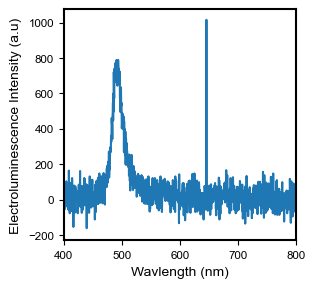

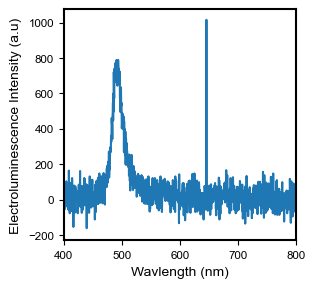

In [9]:
el_spec_au=  np.copy(el_spec_file[:,-1])
el_spec_background= np.copy(el_spec_file[:,1])

plt.figure(figsize=(3,3))
plt.plot(el_spec_nm, el_spec_au-el_spec_background)
plt.xlabel('Wavlength (nm)')
plt.ylabel('Electroluminescence Intensity (a.u)')
plt.xlim(400,800)
plt.show()
#plt.title('Selected EL Spectrum')